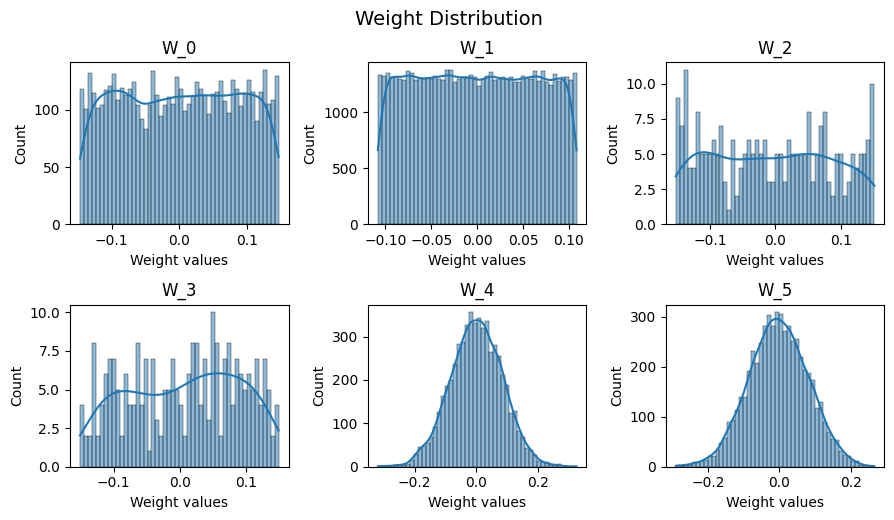

No data to plot.


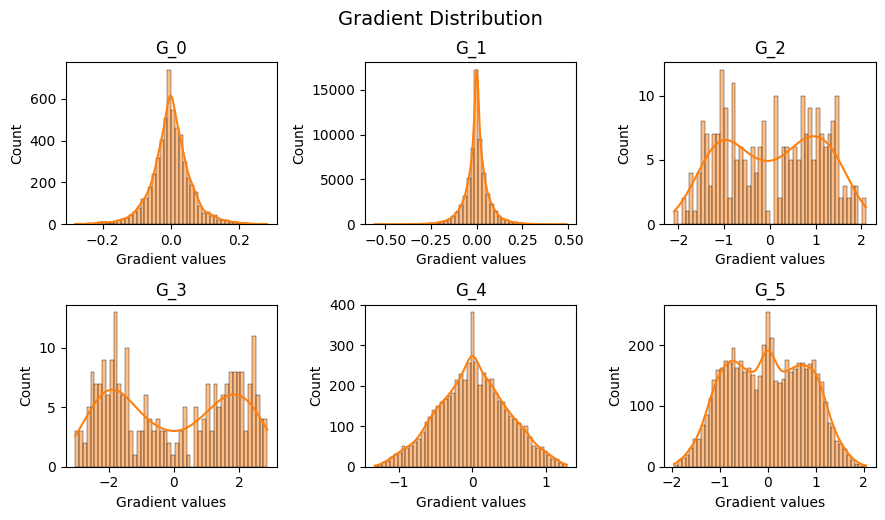

TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.

In [13]:
import jax
import jax.numpy as jnp
import optax
import numpy as onp
import matplotlib.pyplot as plt

from jax import grad, vmap, jit
from flax import linen as nn
from flax.traverse_util import flatten_dict
from jax.tree_util import tree_flatten
from functools import partial
import itertools

# -------------------------------------------------------------------------
# Basic plotting helpers (similar to the Wave PINN example)
# -------------------------------------------------------------------------
def plot_losses(pinn):
    """
    Plot the training losses (total, IC, Residual) logged in the ACPINN instance.
    """
    plt.figure(figsize=(6,4))
    plt.plot(pinn.loss_log,     label="Total loss")
    plt.plot(pinn.loss_ics_log, label="IC loss")
    plt.plot(pinn.loss_res_log, label="Residual loss")
    plt.yscale('log')
    plt.legend()
    plt.title("Losses per iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True, log_scale=False):
    """
    Plot histograms for each array in val_dict.
    """
    import math
    import seaborn as sns

    def _find_subplot_dims_approx_4_3(n: int):
        """
        Find (rows, cols) so that rows*cols >= n and cols/rows ~ 4/3
        """
        best_rc = (1, n)
        best_diff = float('inf')
        for r in range(1, n+1):
            c = math.ceil(n / r)
            if r * c >= n:
                ratio = c / r
                diff = abs(ratio - (4/3))
                if diff < best_diff:
                    best_diff = diff
                    best_rc = (r, c)
        return best_rc

    n_plots = len(val_dict)
    if n_plots == 0:
        print("No data to plot.")
        return None

    rows, cols = _find_subplot_dims_approx_4_3(n_plots)
    fig, axes = plt.subplots(rows, cols, figsize=(3.0*cols, 2.5*rows), squeeze=False)
    axes = axes.ravel()

    for i, key in enumerate(val_dict.keys()):
        vals = val_dict[key].ravel()
        if log_scale:
            # small safeguard for negative values
            vals = jnp.log1p(jnp.abs(vals)) * jnp.sign(vals)
        ax = axes[i]
        sns.histplot(onp.array(vals), ax=ax, color=color, bins=50, stat=stat,
                     kde=(use_kde and onp.std(vals) > 1e-9))
        ax.set_title(f"{key}")
        if xlabel:
            ax.set_xlabel(xlabel)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    fig.tight_layout()
    return fig

def flatten_intermediates(intdict):
    """
    Flatten a nested dictionary of "intermediates" returned 
    by model.apply(..., capture_intermediates=True, mutable=["intermediates"]).
    Returns a dict {name -> np.ndarray}.
    """
    all_acts = {}
    def recurse(prefix, d):
        if isinstance(d, dict):
            for k, v in d.items():
                recurse(prefix + [k], v)
        elif isinstance(d, (list, tuple)):
            for i, v2 in enumerate(d):
                recurse(prefix + [str(i)], v2)
        elif isinstance(d, jnp.ndarray):
            name = "/".join(prefix)
            all_acts[name] = v2 = onp.array(d)
    recurse([], intdict)
    return all_acts

from typing import Sequence, Callable

class ModifiedMLP(nn.Module):
    layers: list   # e.g. [d_in, 256, 256, 256, 1]
    L: float = 2.0
    M: int = 1
    activation: callable = nn.tanh

    def xavier_init(self, rng, shape):
        glorot_stddev = 1.0 / jnp.sqrt((shape[0] + shape[1]) / 2.)
        return glorot_stddev * jax.random.normal(rng, shape)

    @nn.compact
    def __call__(self, t: jnp.ndarray, x: jnp.ndarray) -> jnp.ndarray:
        """
        Forward pass for the modified MLP. 
        :param t: shape=()
        :param x: shape=()
        :return: shape=(1,), i.e. scalar output
        """
        # 1) Input encoding
        def input_encoding(tt, xx):
            w = 2.0 * jnp.pi / self.L
            k = jnp.arange(1, self.M + 1)
            cos_terms = jnp.cos(k * w * xx)
            sin_terms = jnp.sin(k * w * xx)
            # shape is (2*M + 2,)
            return jnp.concatenate([jnp.array([tt, 1.0]), cos_terms, sin_terms], axis=0)

        inputs = input_encoding(t, x)  # (d_in,)

        d_in, d_h, d_out = self.layers[0], self.layers[1], self.layers[-1]

        # -- Create parameters U1, b1, U2, b2 via self.param --
        U1 = self.param(
            "U1", 
            lambda rng: self.xavier_init(rng, (d_in, d_h))
        )
        b1 = self.param(
            "b1",
            lambda rng: jnp.zeros((d_h,))
        )
        U2 = self.param(
            "U2", 
            lambda rng: self.xavier_init(rng, (d_in, d_h))
        )
        b2 = self.param(
            "b2",
            lambda rng: jnp.zeros((d_h,))
        )

        # Compute U, V
        U = self.activation(jnp.dot(inputs, U1) + b1)  # shape=(d_h,)
        V = self.activation(jnp.dot(inputs, U2) + b2)  # shape=(d_h,)

        # Build the rest of the layers
        hidden_layers = []
        # each i from 1 to len(self.layers)-2 means:
        # layers[i] -> layers[i+1], but we skip the final
        for i in range(1, len(self.layers)-1):
            hidden_layers.append(
                nn.Dense(
                    features=self.layers[i+1],
                    kernel_init=nn.initializers.xavier_uniform(),
                    bias_init=nn.initializers.zeros
                )
            )

        z = inputs
        # pass through all but last hidden layer
        for layer_i in hidden_layers[:-1]:
            out_i = self.activation(layer_i(z))
            z = out_i * U + (1.0 - out_i) * V

        # last hidden layer (if any)
        if hidden_layers:
            out_i = self.activation(hidden_layers[-1](z))
            z = out_i * U + (1.0 - out_i) * V

        # final output
        final_layer = nn.Dense(features=d_out,
                               kernel_init=nn.initializers.xavier_uniform(),
                               bias_init=nn.initializers.zeros)
        outputs = final_layer(z)  # shape=(1,)

        return outputs

class ACPINN:
    def __init__(
        self,
        key,
        layers,         # e.g. [d_in, 256, 256, 1]
        M,              # for input encoding
        state0,         # initial condition state at t=0
        x_star,         # array of x-values in the domain
        t0, t1,         # time range
        n_t, n_x,
        nu,             # diffusion coefficient in Allen–Cahn PDE
        tol=1e-2,
        learning_rate=1e-3
    ):
        """
        Allen-Cahn PDE: u_t + 5 u^3 - 5 u - nu * u_xx = 0
        with initial condition from `state0`.

        Key arguments:
          - layers: list, e.g. [d_in, 256, 256, 1]
          - M: number of Fourier modes in the input encoding
          - state0: shape (N_x, 1) initial data
          - x_star: shape (N_x,) the spatial grid
          - (t0, t1): time domain
          - (n_t, n_x): number of collocation points in t and x
          - nu: coefficient in PDE
          - tol: used to compute the exponential weighting W(t)
          - learning_rate: for Adam
        """

        self.key = key
        self.nu = nu
        self.tol = tol

        # Create the model
        self.model = ModifiedMLP(layers=layers, L=2.0, M=M, activation=nn.tanh)

        # Initialize model parameters with a dummy input => shape (1,) for t and x
        # We'll pass t=0.0, x=0.0 to figure out shape
        dummy_t = jnp.array(0.0)
        dummy_x = jnp.array(0.0)
        self.params = self.model.init(self.key, dummy_t, dummy_x)

        # Create an optimizer
        schedule = optax.exponential_decay(
            init_value=learning_rate,
            transition_steps=5000,
            decay_rate=0.9,
            staircase=False
        )
        self.optimizer = optax.adam(schedule)
        self.opt_state = self.optimizer.init(self.params)

        # Collocation points in (t,x) for residual
        self.t0 = t0
        self.t1 = t1
        self.t_r = jnp.linspace(t0, t1, n_t, dtype=jnp.float32)  # shape=(n_t,)
        self.x_r = jnp.linspace(-1.0, 1.0, n_x, dtype=jnp.float32)  # shape=(n_x,)

        # We create the matrix M used in the weighting logic
        # (upper triangular)
        self.M_mat = onp.triu(onp.ones((n_t,n_t), dtype=onp.float32), k=1).T
        self.M_mat = jnp.array(self.M_mat, dtype=jnp.float32)

        # IC 
        # Suppose x_star is shape (N_x,). Then state0 is shape (N_x,1).
        # We'll store them for the initial condition loss
        self.x_star = x_star
        self.state0 = state0  # shape (N_x,1)
        # We'll define "X_ic" = (t=0, x=x_star)
        self.X_ic_t = jnp.zeros_like(x_star, dtype=jnp.float32)  # shape=(N_x,)
        self.X_ic_x = x_star  # shape=(N_x,)

        # Logs
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []

    def neural_net(self, params, t, x):
        """
        Evaluate the NN at scalar t,x => returns scalar u(t,x).
        """
        out = self.model.apply(params, t, x)  # shape=(1,)
        return out[0]

    def residual_net(self, params, t, x):
        """
        PDE residual: R = u_t + 5u^3 - 5u - nu u_xx
        """
        u = self.neural_net(params, t, x)
        # partial derivative w.r.t. t
        u_t = grad(self.neural_net, argnums=1)(params, t, x)
        # partial derivative w.r.t. x
        u_x = grad(self.neural_net, argnums=2)(params, t, x)
        # second derivative w.r.t. x
        u_xx = grad(lambda pp, tt, xx: grad(self.neural_net, argnums=2)(pp, tt, xx),
                    argnums=2)(params, t, x)

        # Allen–Cahn PDE
        #   u_t + 5*u^3 - 5*u - nu*u_xx = 0
        return u_t + 5.0*(u**3) - 5.0*u - self.nu*u_xx

    # -- For weighting logic:
    @partial(jit, static_argnums=0)
    def residuals_and_weights(self, params, tol):
        """
        Evaluate the PDE residual at all collocation points,
        then compute L_t(t_i) = mean_{x}(r^2) for each time slice,
        and the exponential weighting W(t).
        """
        # r_pred shape => (n_t, n_x), each [i,j] => residual(t_i, x_j)
        # Let's vmap over t and x:
        def r_for_fixed_t(tt):
            return vmap(lambda xx: self.residual_net(params, tt, xx))(self.x_r)
        r_pred = vmap(r_for_fixed_t)(self.t_r)  # => shape (n_t, n_x)
        L_t_vals = jnp.mean(r_pred**2, axis=1)  # => shape (n_t,)

        # Exponential weighting
        # W(t_i) = exp( -tol * sum_{k <= i}(L_t_k) ), using the upper triangular
        # matrix self.M_mat. Actually you had M @ L_t in your code.
        # M_mat shape => (n_t, n_t), L_t_vals => (n_t,)
        # so M_mat @ L_t_vals => shape (n_t,)
        M_dot = self.M_mat @ L_t_vals
        W = jnp.exp(-tol * M_dot)  # shape (n_t,)

        return L_t_vals, W

    @partial(jit, static_argnums=0)
    def loss_ics(self, params):
        """
        Initial condition loss: at t=0, we want u(0, x) ~ state0(x)
        """
        # Evaluate the network over IC
        def fn_i(xx):
            return self.neural_net(params, 0.0, xx)
        u_pred = vmap(fn_i)(self.X_ic_x)  # shape (N_x,)
        # MSE
        ic_true = self.state0.flatten()
        return jnp.mean((ic_true - u_pred)**2)

    @partial(jit, static_argnums=0)
    def loss_res(self, params):
        """
        Mean squared PDE residual across all collocation points.
        """
        def r_for_fixed_t(tt):
            return vmap(lambda xx: self.residual_net(params, tt, xx))(self.x_r)
        r_pred = vmap(r_for_fixed_t)(self.t_r)  # => shape (n_t, n_x)
        return jnp.mean(r_pred**2)

    @partial(jit, static_argnums=0)
    def loss(self, params):
        """
        Weighted PDE loss + initial condition loss.
          L0 = 100 * IC_loss
          PDE_loss = mean(W * L_t(t_i))
        """
        L0 = 100.0 * self.loss_ics(params)
        L_t_vals, W_vals = self.residuals_and_weights(params, self.tol)
        # PDE loss = mean(W * L_t)
        pde_loss = jnp.mean(W_vals * L_t_vals)
        return pde_loss + L0

    @partial(jit, static_argnums=0)
    def update_step(self, i, opt_state):
        """
        One training step with Adam updates.
        """
        params = self.get_params(opt_state)
        l, grads = jax.value_and_grad(self.loss)(params)
        updates, opt_state = self.optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, l, grads

    def get_params(self, opt_state):
        """
        Returns current parameters from opt_state.
        """
        # Typically we track them ourselves, but we can store them in self.params
        # or re-pack them. We'll do it the same as wave code:
        # We'll do a small hack: we want the "params" from the last step.
        # We'll just re-apply the same update logic we used.
        return opt_state[1]  # (for some versions of optax) 
        # If that doesn't work, consider storing them explicitly or using an Optax "inject_hyperparams" approach.
        # Alternatively, store them in self.params each iteration.

    def set_params(self, params, opt_state):
        """
        Helper if needed, to place new param values in the optimizer state.
        Not always needed, but shown for completeness.
        """
        # This is one approach to keep them in sync. Implementation depends on how you store the state.
        pass

    def train(self, nIter=10000, print_every=1000):
        pbar = range(nIter)
        opt_state = self.opt_state
        for it in pbar:
            params, opt_state, loss_val, grads = self.update_step(it, opt_state)
            self.params = params  # store updated
            self.opt_state = opt_state

            if it % print_every == 0:
                loss_value = self.loss(params)
                loss_ics_val = self.loss_ics(params)
                loss_res_val = self.loss_res(params)
                L_t_val, W_val = self.residuals_and_weights(params, self.tol)

                self.loss_log.append(float(loss_value))
                self.loss_ics_log.append(float(loss_ics_val))
                self.loss_res_log.append(float(loss_res_val))
                self.W_log.append(onp.array(W_val))
                self.L_t_log.append(onp.array(L_t_val))

                print(f"Iter={it} | Loss={loss_value:.3e} | IC={loss_ics_val:.3e} | Res={loss_res_val:.3e} | W_min={W_val.min():.4f}")
                
                # Early stop if W_min > 0.99
                if W_val.min() > 0.99:
                    break

    # ---------------------------------------------------------------------
    #  (A) Activation capture
    # ---------------------------------------------------------------------
    def get_intermediates(self, params, t_array, x_array):
        """
        Return (final_output, intermediates_dict) for a batch of (t,x).
        We'll flatten them in the same style as the wave code. 
        """
        # Example input shape => (N,2). We'll handle that by vmap at the top-level
        # But for capturing intermediates, we can pass a single sample or a batch.
        def single_apply(tx):
            t_s, x_s = tx
            # "capture_intermediates=True" requires a single call
            out, info = self.model.apply(
                params, t_s, x_s,
                capture_intermediates=True,
                mutable=["intermediates"]
            )
            return out, info["intermediates"]

        # We'll just capture one sample if needed. If we want a batch approach, 
        # we can do complicated merges. For demonstration, let's pick the first point.
        t0, x0 = t_array[0], x_array[0]
        out, info = self.model.apply(
            params, t0, x0,
            capture_intermediates=True,
            mutable=["intermediates"]
        )
        return out, info["intermediates"]

    # ---------------------------------------------------------------------
    #  (B) Compute Gradients
    # ---------------------------------------------------------------------
    def get_gradients(self, params):
        """
        Return the PyTree of gradients w.r.t. the PDE loss.
        """
        grads = jax.grad(self.loss)(params)
        return grads

    # ---------------------------------------------------------------------
    # Predict function (2D array of t,x)
    # ---------------------------------------------------------------------
    def predict(self, t_array, x_array):
        """
        Evaluate the model on arrays t_array (shape=(T,)) and x_array (shape=(X,)),
        returning shape (T, X).
        """
        # We'll do vmap over t, then x
        def pred_t(tt):
            def pred_x(xx):
                return self.neural_net(self.params, tt, xx)
            return vmap(pred_x)(x_array)
        return vmap(pred_t)(t_array)


def plot_weight_distributions(pinn):
    """
    Flatten only the 'weight' parameters in pinn.params (where p.ndim>1)
    and plot their distributions.
    """
    flat_params = tree_flatten(pinn.params)[0]
    weight_vals = {}
    w_idx = 0
    for p in flat_params:
        if p.ndim > 1:  # treat multi-dim arrays as "weights"
            weight_vals[f"W_{w_idx}"] = onp.array(p).ravel()
            w_idx += 1
    fig = plot_dists(weight_vals, color="C0", xlabel="Weight values")
    if fig is not None:
        fig.suptitle("Weight Distribution", fontsize=14, y=1.03)
        plt.show()

def plot_gradient_distributions(pinn):
    """
    Compute PDE gradients w.r.t. pinn.params, flatten only 'weight' grads,
    and plot them.
    """
    grads = pinn.get_gradients(pinn.params)
    leaves = tree_flatten(grads)[0]
    grad_vals = {}
    g_idx = 0
    for g in leaves:
        if g.ndim > 1:
            grad_vals[f"G_{g_idx}"] = onp.array(g).ravel()
            g_idx += 1
    fig = plot_dists(grad_vals, color="C1", xlabel="Gradient values", log_scale=True)
    if fig is not None:
        fig.suptitle("Gradient Distribution", fontsize=14, y=1.03)
        plt.show()

def plot_activation_distributions(pinn, t_sample, x_sample):
    """
    Capture the intermediate activations of the forward pass
    and plot them.
    """
    # We'll call get_intermediates on a single sample t_sample, x_sample,
    # or an entire batch if you prefer. For demonstration:
    out, intermediates = pinn.get_intermediates(pinn.params, t_sample, x_sample)
    flat_acts = flatten_intermediates(intermediates)

    activations_dict = {}
    idx = 0
    for name, arr in flat_acts.items():
        if arr.ndim > 1:
            activations_dict[f"Act_{idx}({name})"] = arr.ravel()
            idx += 1

    fig = plot_dists(activations_dict, color="C2", stat="density", xlabel="Activation values")
    if fig is not None:
        fig.suptitle("Activation Distribution", fontsize=14, y=1.03)
        plt.show()


# Example usage (pseudo-code)

import scipy.io
import matplotlib.pyplot as plt

# 1) Load data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']          # shape (N_x, N_t)
t_star = data['tt'][0]     # shape (N_t,)
x_star = data['x'][0]      # shape (N_x,)
nu = 0.0001  # diffusion coefficient

x_star = jnp.array(x_star, dtype=jnp.float32)
t_star = jnp.array(t_star, dtype=jnp.float32)
usol   = jnp.array(usol,   dtype=jnp.float32)



# 2) Build and train PINN
key = jax.random.PRNGKey(1234)
M = 10
d_in = 2*M + 2   # input dimension for the periodic encoding
layers = [d_in, 256, 256, 256, 1]

t0, t1 = 0.0, 1.0
n_t, n_x = 100, 256
state0 = usol[:, 0:1]  # initial condition at t=0

pinn = ACPINN(
    key, layers, M,
    state0=state0,
    x_star=x_star,
    t0=t0, t1=t1,
    n_t=n_t, n_x=n_x,
    nu=nu,
    tol=1e-2,
    learning_rate=1e-3
)



# 4) Plot weight/activation/gradient distributions
plot_weight_distributions(pinn)
plot_activation_distributions(pinn, t_star, x_star)  # for some sample points
plot_gradient_distributions(pinn)


# 3) Train
pinn.train(nIter=1, print_every=1000)
plot_losses(pinn)



# 5) Evaluate solution
u_pred = pinn.predict(t_star, x_star)  # => shape (N_t, N_x)
# Compare to usol (which might be shape (N_x, N_t), so be mindful of transposes)
error = onp.linalg.norm(u_pred.T - usol) / onp.linalg.norm(usol)
print(f"Relative L2 error: {error:.3e}")
